In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Dataset Import

In [2]:
# Path to your dataset
dataset_path = r"D:\Gender Age Detector\archive\UTKFace"

# Initialize lists to store images and corresponding age labels
images = []
ages = []

# Loop through all image files in the dataset directory
for filename in tqdm(os.listdir(dataset_path)):
    if filename.endswith(".jpg"):
        try:
            # Extract age from filename (Format: age_gender_race_date.jpg)
            age = int(filename.split("_")[0])
            
            # Read image using OpenCV
            img_path = os.path.join(dataset_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            
            images.append(img)
            ages.append(age)
        except Exception as e:
            print(f"Skipping file {filename}: {e}")

100%|████████████████████████████████████████████████████████████████████████████| 23708/23708 [04:53<00:00, 80.81it/s]


In [5]:
# Normalize image data to range [0, 1]
images = images.astype('float32') / 255.0

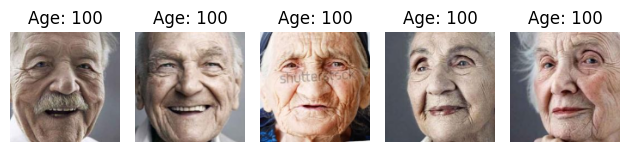

In [6]:
import matplotlib.pyplot as plt

# Display the first 5 images with their corresponding ages
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(f'Age: {ages[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Preprocessing

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Convert age labels to float32
ages = ages.astype('float32')

# Optional: If you want to scale ages between 0 and 1
scaler = MinMaxScaler()
ages = scaler.fit_transform(ages.reshape(-1, 1)).flatten()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, ages, test_size=0.2, random_state=42)

# Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1)  # Regression output for age
])

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,+
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/60
475/475 [==============================] - 479s 1s/step - loss: 4.8803 - mae: 0.4310 - val_loss: 1.0178 - val_mae: 0.2352 - lr: 0.0010
Epoch 2/60
475/475 [==============================] - 481s 1s/step - loss: 0.7812 - mae: 0.1423 - val_loss: 0.7219 - val_mae: 0.1215 - lr: 0.0010
Epoch 3/60
475/475 [==============================] - 505s 1s/step - loss: 0.6754 - mae: 0.1282 - val_loss: 0.6174 - val_mae: 0.0996 - lr: 0.0010
Epoch 4/60
475/475 [==============================] - 499s 1s/step - loss: 0.5786 - mae: 0.1141 - val_loss: 0.5310 - val_mae: 0.0974 - lr: 0.0010
Epoch 5/60
475/475 [==============================] - 471s 991ms/step - loss: 0.4961 - mae: 0.1093 - val_loss: 0.4587 - val_mae: 0.1063 - lr: 0.0010
Epoch 6/60
475/475 [==============================] - 479s 1s/step - loss: 0.4242 - mae: 0.1047 - val_loss: 0.3872 - val_mae: 0.0859 - lr: 0.0010
Epoch 7/60
475/475 [==============================] - 494s 1s/step - loss: 0.3624 - mae: 0.0973 - val_loss: 0.3323 - val_

In [16]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

149/149 [==============================] - 23s 152ms/step - loss: 0.2409 - mae: 0.0878
Test Loss: 0.2409
Test MAE: 0.0878


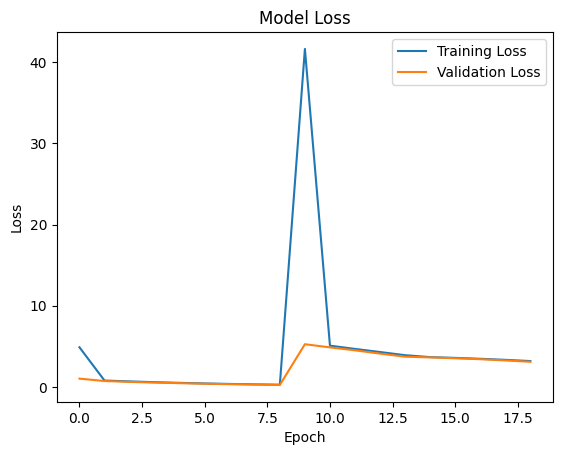

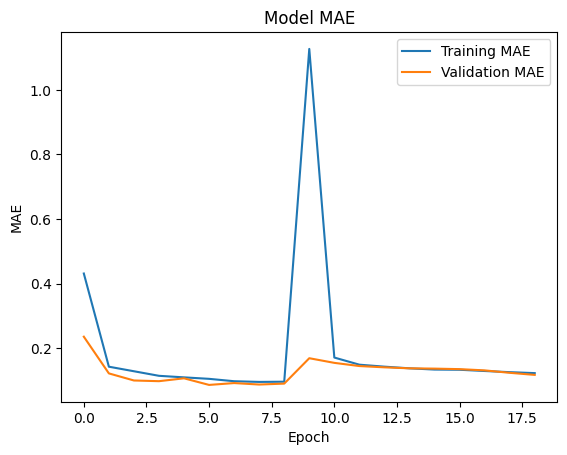

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
accuracy = 100 - mae  # approximate age prediction accuracy
print(f"Approximate Accuracy: {accuracy:.2f}%")

149/149 [==============================] - 22s 145ms/step
Approximate Accuracy: 99.91%


# Saving Model

In [21]:
model.save("age_detection_model.h5")

C:\Users\VISHWA\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
